In [31]:
import sys
sys.path.append('..')

In [32]:
from curry.loader import Loader

In [33]:
from curry.features import Extractor

In [34]:
import seaborn as sns
import pandas as pd
import pickle
from tqdm import tqdm

In [35]:
loader = Loader()

In [36]:
extractor = Extractor(cache_dir='../data/cache/')

In [37]:
df, _, _ = loader.sublessons_w_content(False, None)

In [8]:
df.groupby('land').apply(lambda df: set(df.klass.values))

land
baden-wuerttemberg            {5, 6, 7, 8, 9, 10, 11, 12}
bayern                           {5, 7, 8, 9, 10, 11, 12}
berlin                        {5, 6, 7, 8, 9, 10, 11, 12}
brandenburg                   {5, 6, 7, 8, 9, 10, 11, 12}
bremen                        {5, 6, 7, 8, 9, 10, 11, 12}
hamburg                       {5, 6, 7, 8, 9, 10, 11, 12}
hessen                             {7, 8, 10, 11, 12, 13}
mecklenburg-vorpommern           {6, 7, 8, 9, 10, 11, 12}
niedersachsen             {5, 6, 7, 8, 9, 10, 11, 12, 13}
nordrhein-westfalen           {5, 6, 7, 8, 9, 10, 11, 12}
rheinland-pfalz              {5, 6, 8, 9, 10, 11, 12, 13}
saarland                            {7, 8, 9, 10, 11, 12}
sachsen                          {6, 7, 8, 9, 10, 11, 12}
sachsen-anhalt                   {6, 7, 8, 9, 10, 11, 12}
schleswig-holstein               {6, 7, 8, 9, 10, 11, 12}
thueringen                    {5, 6, 7, 8, 9, 10, 11, 12}
dtype: object

In [38]:
df['simple_level'] = df.klass.apply(
    lambda c: 'primary' if c <=5 else ('sec1' if c <= 9 else 'sec2'))

In [39]:
secondary = df[df.simple_level != 'primary']

<AxesSubplot:xlabel='land', ylabel='Count'>

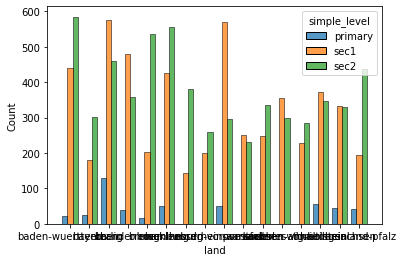

In [10]:
sns.histplot(data=df, x="land", hue="simple_level", multiple="dodge", shrink=.8)

In [11]:
secondary = df[df.simple_level != 'primary']

In [65]:
with open('../data/cache/babelfied.cache', 'rb') as f:
    babelfy = pickle.load(f)


In [60]:
with open('../data/cache/wikified.cache', 'rb') as f:
    wikified = pickle.load(f)


In [96]:
page_ranks = []
cosines = []

for k in wikified:
    v = wikified[k]
    for a in v['annotations']:
        page_ranks.append(a['pageRank'])
        cosines.append(a['cosine'])

<AxesSubplot:ylabel='Frequency'>

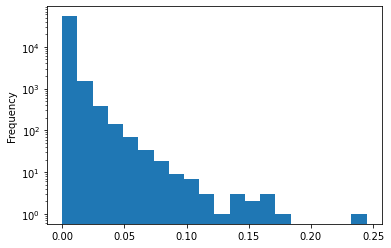

In [104]:
pd.Series(page_ranks).plot(kind='hist', logy=True, bins=20)

<AxesSubplot:ylabel='Frequency'>

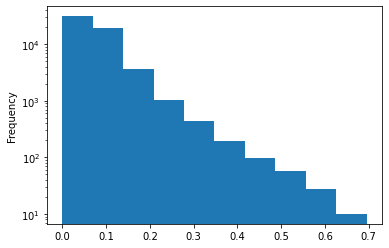

In [103]:
pd.Series(cosines).plot(kind='hist', logy=True)

In [133]:
count = 0
wikified_dbpedia_iris = []
for k in wikified:
    w = wikified[k]
    for a in w['annotations']:
        count += 1
        if a.get('dbPediaIri') and a['cosine']>0.1:
            wikified_dbpedia_iris.append(a.get('dbPediaIri'))
            
len(wikified_dbpedia_iris) / count

0.21067585325141172

In [134]:
babelfy_dbpedia_iris = list()

for values in babelfy.values():
    for value in values:
        if value.get('DBpediaURL'):
            babelfy_dbpedia_iris.append(value.get('DBpediaURL'))

In [135]:
len(set(babelfy_dbpedia_iris))

3280

In [137]:
all_dbpedia_iris = set(wikified_dbpedia_iris).union(set(babelfy_dbpedia_iris))
len(all_dbpedia_iris)

5092

In [138]:
entities = pd.Series(wikified_dbpedia_iris + babelfy_dbpedia_iris).value_counts().sort_values(ascending=False)

In [139]:
entities

http://dbpedia.org/resource/Fundamental_science          571
http://dbpedia.org/resource/Force                        507
http://dbpedia.org/resource/Thermodynamic_free_energy    452
http://dbpedia.org/resource/Physical_body                442
http://dbpedia.org/resource/Light                        425
                                                        ... 
http://de.dbpedia.org/resource/Messbereich                 1
http://dbpedia.org/resource/Wound                          1
http://dbpedia.org/resource/Henri_Becquerel                1
http://dbpedia.org/resource/Building                       1
http://dbpedia.org/resource/O                              1
Length: 5092, dtype: int64

In [140]:
import sparql_dataframe
from functools import lru_cache

@lru_cache(maxsize=4000)
def get_rdf_type(resource, depth):
    endpoint = "http://dbpedia.org/sparql"

    q = """
        prefix dbr: <http://dbpedia.org/resource/> 
        prefix dbo: <http://dbpedia.org/ontology/>
        prefix skos: <http://www.w3.org/2004/02/skos/core#>

        select distinct ?subcategory  where {
          <""" + resource + """> dbo:wikiPageRedirects* ?redirect.
          ?redirect <http://purl.org/dc/terms/subject> ?category.
          ?category """ + '?/'.join(['skos:broader' for _ in range(depth)]) + """ ?subcategory
        }
    """
    df = sparql_dataframe.get(endpoint, q)
    return df.subcategory.values

In [141]:
categories = [get_rdf_type(r, 5) for r in tqdm(entities.index)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5092/5092 [22:10<00:00,  3.83it/s]


In [142]:
categories_by_iri = dict(zip(entities.index, categories))

In [144]:
# with open('../data/cache/categories_depth_5.pkl', 'wb') as f:
#     pickle.dump(categories_by_iri, f)

In [146]:
with open('../data/cache/categories_depth_5.pkl', 'rb') as f:
    categories_by_iri = pickle.load(f)

In [66]:
categories_ordered = [categories_by_entity[e] for e in entities.index]

In [147]:
all_categories = pd.Series([c for e in entities.index for c in categories_by_iri[e]]).value_counts().sort_values(ascending=False)

In [149]:
def is_accepted_topics(c):
    return ('http://dbpedia.org/resource/Category:Subfields_of_physics' in c) or \
    ('http://dbpedia.org/resource/Category:Physics' in c) or \
    ('http://dbpedia.org/resource/Category:Concepts_in_physics' in c) or \
    ('http://dbpedia.org/resource/Category:Physical_sciences' in c) or \
    ('http://dbpedia.org/resource/Category:Electromagnetism' in c) or \
    ('http://dbpedia.org/resource/Category:Electrical_engineering' in c) or \
    ('http://dbpedia.org/resource/Category:Physical_quantities' in c) or \
    ('http://dbpedia.org/resource/Category:Universe' in c) or \
    ('http://dbpedia.org/resource/Category:Metrology' in c) or \
    ('http://dbpedia.org/resource/Category:Classical_mechanics' in c) or \
    ('http://dbpedia.org/resource/Category:Engineering_disciplines' in c) or \
    ('http://dbpedia.org/resource/Category:Applied_and_interdisciplinary_physics' in c) or \
    ('http://dbpedia.org/resource/Category:Applied_sciences' in c) or \
    ('http://dbpedia.org/resource/Category:Engineering_disciplines' in c)

In [150]:
entities[[any([is_accepted_topics(c) for c in categories_by_iri[e]]) for e in entities.index]].shape[0] / entities.shape[0]

0.7802435192458759

In [171]:
relevant_annotations_filtered_babel = dict()
for url in babelfy:
    out = []
    bs = babelfy[url]
    for b in bs:
        if b.get('DBpediaURL') and b['score'] > 0.5:
            if any([is_accepted_topics(c) for c in categories_by_iri[b['DBpediaURL']]]):
                out.append(b['DBpediaURL'])
    relevant_annotations_filtered_babel[url] = out

In [172]:
relevant_annotations_babel = dict()
for url in babelfy:
    out = []
    bs = babelfy[url]
    for b in bs:
        if b.get('DBpediaURL'):
            if any([is_accepted_topics(c) for c in categories_by_iri[b['DBpediaURL']]]):
                out.append(b['DBpediaURL'])
    relevant_annotations_babel[url] = out

In [173]:
relevant_annotations_filtered_wikifier = dict()
for url in wikified:
    out = []
    bs = wikified[url]
    for b in bs['annotations']:
        if b.get('dbPediaIri') and b['cosine'] > 0.2:
            if any([is_accepted_topics(c) for c in categories_by_iri[b['dbPediaIri']]]):
                out.append(b['dbPediaIri'])
    relevant_annotations_filtered_wikifier[url] = out

In [174]:
relevant_annotations_wikifier = dict()
for url in wikified:
    out = []
    bs = wikified[url]
    for b in bs['annotations']:
        if b.get('dbPediaIri') and b['cosine'] > 0.1:
            if any([is_accepted_topics(c) for c in categories_by_iri[b['dbPediaIri']]]):
                out.append(b['dbPediaIri'])
    relevant_annotations_wikifier[url] = out

In [175]:
def get_no_annotations(relevant_annotations):
    no_annotations = []
    for k in relevant_annotations:
        v = relevant_annotations[k]
    #     lengths.append(len(v))
        if v == []:
            no_annotations.append(k)

    return no_annotations

1. one => Babelfy doesn't recognize Hooke's Law
2. Many sentences are stripped out because of containing equational material
3. Prob. same as above. Stripped out in preprocessing

In [176]:
def get_clean(relevant_annotations):
    no_annotations = get_no_annotations(relevant_annotations)
    multiple_levels = secondary.groupby(['land', 'grundwissen_url']).simple_level.unique()
    one_level_mask = secondary[['land', 'grundwissen_url']].apply(tuple, axis=1).isin(
        multiple_levels[multiple_levels.apply(len) == 1].index
    )
    one_level_subset=secondary[one_level_mask]
    clean_one_level = one_level_subset.drop(columns=['klass']).drop_duplicates()
    if no_annotations:
        clean_one_level = clean_one_level[~clean_one_level.grundwissen_url.isin(no_annotations)]
    return clean_one_level

In [167]:
from curry.model import Trainer,  Models

In [168]:
trainer = Trainer(data_dir='../data/')

In [190]:
def train(relevant_annotations):
    results = dict()
    for land in tqdm(clean_one_level.land.unique()):
        features, featur_names = extractor.count_vectorize(
        [relevant_annotations[c] for c 
         in clean_one_level[clean_one_level.land == land].grundwissen_url])
        results[land] = trainer.kfold(
        Models.xgbClassifier(10, num_class=2),
        features,
        clean_one_level[clean_one_level.land == land].simple_level.astype('category').cat.codes.values,
        featur_names)
    return results

In [191]:
results_babel_cat_filtered = train(relevant_annotations_babel)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


In [194]:
results_babel_cat_score_fitered = train(relevant_annotations_filtered_babel)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


In [195]:
results_wikifier_cat_score_fitered = train(relevant_annotations_filtered_wikifier)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


In [196]:
results_wikifier_cat_fitered = train(relevant_annotations_wikifier)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


In [183]:
results_baseline_babel = dict()
for land in tqdm(clean_one_level.land.unique()):
    features, featur_names = extractor.count_vectorize(
    [[a.get('DBpediaURL', a['text']) for a in babelfy[c]] for c 
     in clean_one_level[clean_one_level.land == land].grundwissen_url])
    results_baseline_babel[land] = trainer.kfold(
    Models.xgbClassifier(10, num_class=2),
    features,
    clean_one_level[clean_one_level.land == land].simple_level.astype('category').cat.codes.values,
    featur_names)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


In [186]:
results_baseline_wikifier = dict()
for land in tqdm(clean_one_level.land.unique()):
    features, featur_names = extractor.count_vectorize(
    [[a['title'] for a in wikified[c]['annotations']] for c 
     in clean_one_level[clean_one_level.land == land].grundwissen_url])
    results_baseline_wikifier[land] = trainer.kfold(
    Models.xgbClassifier(10, num_class=2),
    features,
    clean_one_level[clean_one_level.land == land].simple_level.astype('category').cat.codes.values,
    featur_names)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


In [212]:
with open('../data/cache/sentence_transformers.cache', 'rb') as f:
    doc_vecs = pickle.load(f)

In [214]:
results_baseline_st = dict()
for land in tqdm(clean_one_level.land.unique()):
    features = np.array([doc_vecs[u] for u in
        clean_one_level[clean_one_level.land == land].grundwissen_url])
    results_baseline_st[land] = trainer.kfold(
    Models.xgbClassifier(10, num_class=2),
    features,
    clean_one_level[clean_one_level.land == land].simple_level.astype('category').cat.codes.values,
    featur_names)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.26s/it]


In [187]:
import numpy as np

In [216]:
two_level_model_results = pd.DataFrame(
    [(l, 
      np.sum(results_babel_cat_filtered[l][0]['confusion_matrix']) ,
      results_babel_cat_filtered[l][0]['accuracy'],
      results_babel_cat_score_fitered[l][0]['accuracy'],
      results_baseline_babel[l][0]['accuracy'],
      results_wikifier_cat_fitered[l][0]['accuracy'],
      results_wikifier_cat_score_fitered[l][0]['accuracy'],
      results_baseline_wikifier[l][0]['accuracy'],
      results_baseline_st[l][0]['accuracy']
     ) for l in results_babel_cat_filtered], 
    columns=['land', 
             'total', 
             'babel: accuracy w/ domain filtering', 
             'babel: accuracy w/ domain + score filtering',
             'babel: accuracy w/ no filtering', 
             'wikifier: accuracy w/ domain filtering', 
             'wikifier: accuracy w/ domain + score filtering',
             'wikifier: accuracy w/ no filtering',
             'document vectors']).set_index('land')

In [217]:
two_level_model_results.\
    style.highlight_max(color='lightgreen').highlight_min(color='red')

,total,babel: accuracy w/ domain filtering,babel: accuracy w/ domain + score filtering,babel: accuracy w/ no filtering,wikifier: accuracy w/ domain filtering,wikifier: accuracy w/ domain + score filtering,wikifier: accuracy w/ no filtering,document vectors
land,,,,,,,,
baden-wuerttemberg,287,0.679203,0.658406,0.696637,0.665534,0.679605,0.658553,0.700475
bayern,403,0.694877,0.680007,0.669965,0.665082,0.608034,0.660088,0.756845
berlin,246,0.650407,0.621951,0.650407,0.691057,0.699187,0.747967,0.719512
brandenburg,208,0.629952,0.519462,0.605935,0.648930,0.524569,0.673292,0.706970
bremen,373,0.705226,0.689032,0.707892,0.688925,0.731914,0.718624,0.716000
hamburg,267,0.722846,0.685393,0.681648,0.704120,0.655431,0.640449,0.797753
hessen,476,0.670170,0.640740,0.668100,0.653478,0.703819,0.682841,0.716477
mecklenburg-vorpommern,375,0.528000,0.552000,0.525333,0.626667,0.536000,0.648000,0.629333
nordrhein-westfalen,403,0.595522,0.598102,0.625189,0.650028,0.570831,0.595522,0.689773


In [221]:
two_level_model_results.drop(columns=[
    'total',
    'babel: accuracy w/ domain filtering', 
    'babel: accuracy w/ domain + score filtering',
    'babel: accuracy w/ no filtering',
    'document vectors'
]).transpose().\
    style.highlight_max(color='lightgreen').highlight_min(color='red')

land,baden-wuerttemberg,bayern,berlin,brandenburg,bremen,hamburg,hessen,mecklenburg-vorpommern,nordrhein-westfalen,saarland,sachsen,sachsen-anhalt,schleswig-holstein,thueringen,niedersachsen,rheinland-pfalz
wikifier: accuracy w/ domain filtering,0.665534,0.665082,0.691057,0.648930,0.688925,0.704120,0.653478,0.626667,0.650028,0.631709,0.650138,0.649374,0.552113,0.670886,0.552860,0.640908
wikifier: accuracy w/ domain + score filtering,0.679605,0.608034,0.699187,0.524569,0.731914,0.655431,0.703819,0.536000,0.570831,0.542259,0.617080,0.557965,0.547284,0.673732,0.635215,0.689376
wikifier: accuracy w/ no filtering,0.658553,0.660088,0.747967,0.673292,0.718624,0.640449,0.682841,0.648000,0.595522,0.670053,0.606061,0.652433,0.571294,0.696867,0.605507,0.640908


In [222]:
two_level_model_results.drop(columns=[
    'total',
    'wikifier: accuracy w/ domain filtering', 
    'wikifier: accuracy w/ domain + score filtering',
    'wikifier: accuracy w/ no filtering', 
    'document vectors'
]).transpose().\
    style.highlight_max(color='lightgreen').highlight_min(color='red')

land,baden-wuerttemberg,bayern,berlin,brandenburg,bremen,hamburg,hessen,mecklenburg-vorpommern,nordrhein-westfalen,saarland,sachsen,sachsen-anhalt,schleswig-holstein,thueringen,niedersachsen,rheinland-pfalz
babel: accuracy w/ domain filtering,0.679203,0.694877,0.650407,0.629952,0.705226,0.722846,0.670170,0.528000,0.595522,0.624153,0.592287,0.628107,0.514554,0.673631,0.609210,0.667531
babel: accuracy w/ domain + score filtering,0.658406,0.680007,0.621951,0.519462,0.689032,0.685393,0.640740,0.552000,0.598102,0.608808,0.553719,0.619155,0.505164,0.645127,0.590441,0.657851
babel: accuracy w/ no filtering,0.696637,0.669965,0.650407,0.605935,0.707892,0.681648,0.668100,0.525333,0.625189,0.629262,0.578512,0.579233,0.472032,0.663275,0.507916,0.669964


In [223]:
two_level_model_results.drop(columns='total').transpose().mean(axis=1)

babel: accuracy w/ domain filtering               0.636605
babel: accuracy w/ domain + score filtering       0.614085
babel: accuracy w/ no filtering                   0.620706
wikifier: accuracy w/ domain filtering            0.646363
wikifier: accuracy w/ domain + score filtering    0.623269
wikifier: accuracy w/ no filtering                0.654279
document vectors                                  0.693968
dtype: float64

In [88]:
two_level_model_results.accuracy.mean()

0.6210403977768351

In [ ]:
two_level_model_results = pd.DataFrame(
    [(l, 
      np.sum(results[l][0]['confusion_matrix']) ,
      results[l][0]['accuracy']
     ) for l in results], 
    columns=['land', 'total', 'accuracy']).set_index('land')

In [109]:
with open('../data/cache/categories_sorted_by_resource_freq.pkl', 'rb') as f:
    cat_r_freq = pickle.load(f)

In [101]:
entities.index[[
    (('http://dbpedia.org/resource/Category:Physical_chemistry' in c) and
     (not is_accepted_topics(c))
    ) for c in categories_ordered]]

Index(['http://dbpedia.org/resource/Cloud',
       'http://dbpedia.org/resource/Bottle',
       'http://dbpedia.org/resource/Dust',
       'http://dbpedia.org/resource/Vitreous_humour',
       'http://dbpedia.org/resource/Constantan',
       'http://dbpedia.org/resource/Viscose',
       'http://dbpedia.org/resource/Sled',
       'http://dbpedia.org/resource/Dry_cleaning',
       'http://dbpedia.org/resource/Synovial_fluid',
       'http://dbpedia.org/resource/Rainwater_tank',
       'http://dbpedia.org/resource/Mineral_dust',
       'http://dbpedia.org/resource/Brush',
       'http://dbpedia.org/resource/Phosphoric_acid',
       'http://dbpedia.org/resource/Ice_cube'],
      dtype='object')

In [97]:
entities.shape[0]

3280

In [98]:
len([c for c in categories if is_accepted_topics(c)])

1773